# Using Neural Networks on Two Simple Datasets

## Classification

In [1]:
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pymc3 as pm
import pickle
import theano
import theano.tensor as T
import os
import matplotlib
from sklearn.model_selection import train_test_split
import seaborn as sns
%matplotlib inline

### Creating the data and the initial plot of the whole set

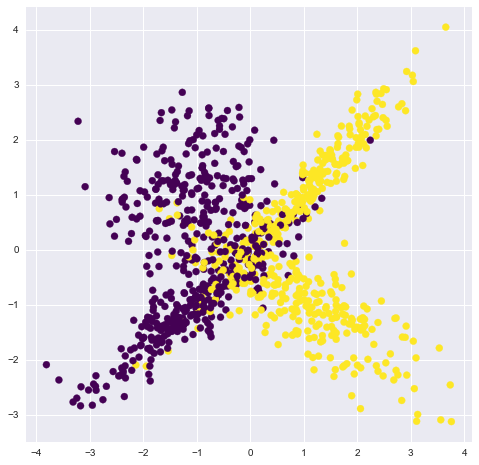

In [616]:
if os.path.exists("class_data2-"):
    with open("class_data2","rb") as f:
        data = pickle.load(f)
else:
    data = make_classification(n_samples=1000,n_features=2,n_redundant=0, class_sep=1, n_clusters_per_class=2, hypercube=True)

X = data[0]
y = data[1]

df = pd.DataFrame(X)
plt.figure(figsize=(8,8))
plt.scatter(df[0], df[1], c=y,cmap="viridis")

In [688]:
pm.Normal?

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [noise]
>Metropolis: [X_interval__]
100%|██████████| 1500/1500 [00:00<00:00, 2209.87it/s]


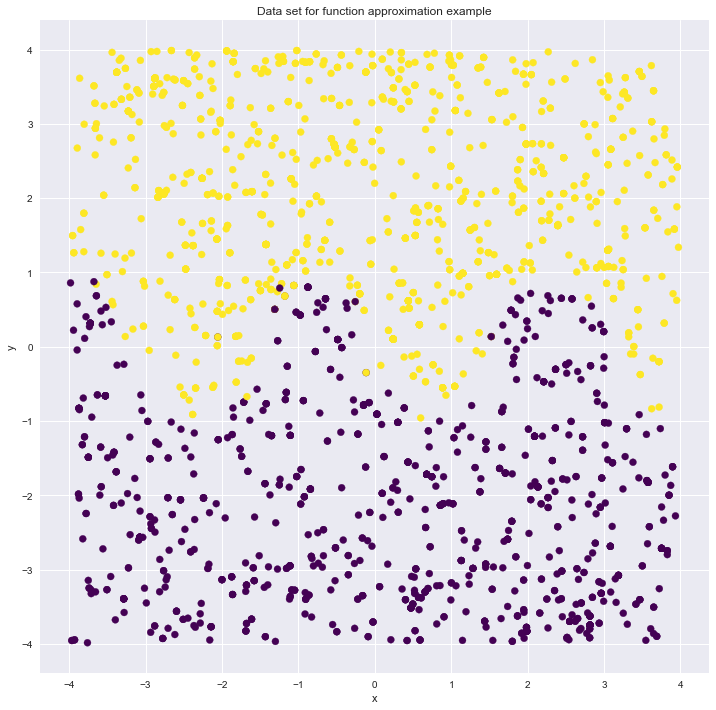

In [54]:
m = pm.Model()
lower=-4
upper=4
N=1000
with m:
    X = pm.Uniform("X", lower=lower, upper=upper, shape=(2))
    #x = X.copy()
    noise = pm.Normal("noise", mu=0, sd=1) # Bunu da pozisyona göre değiştirelim
    #noise = pm.Normal("noise", mu=0, sd=np.sqrt(abs(upper+0.1-X[0]))) # Bunu da pozisyona göre değiştirelim
    y = pm.Deterministic("y", noise + 4*np.sin(X[0]*2)+(6*X[1]**3) > 0)
    step=pm.Metropolis()
    trace = pm.sample(N, step=step)

X = trace.get_values("X")
y = trace.get_values("y")

#data = [X, y]
#with open("reg_data","wb") as f:
    #pickle.dump(data, f)
        
plt.figure(figsize=(12,12))
plt.title("Data set for function approximation example")
plt.ylabel("y")
plt.xlabel("x")
plt.scatter(X[:,0], X[:,1] ,c=y, cmap="viridis")

In [55]:
X = pd.DataFrame(X)
X["1"] = 1
X = X.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [56]:
N=1000
n_units=5

init_in_1 = np.random.randn(X.shape[1], n_units)
init_1_2 = np.random.randn(n_units + 1, n_units)
init_2_out = np.random.randn(n_units + 1, 1)

In [57]:

ann_input = theano.shared(X_train)
#ann_input = theano.shared(np.reshape(X_train, (len(X_train),1)))
ann_output = theano.shared(y_train)

mlc = pm.Model()
with mlc: 
    w_in_1 = pm.Normal("w_in_1", 0, 1, shape=(X.shape[1], n_units), testval=init_in_1)
    w_1_2 = pm.Normal("w_1_2", 0, 1, shape=(n_units + 1, n_units), testval=init_1_2)
    w_2_out = pm.Normal("w_2_out", 0, 1, shape=(n_units + 1, 1), testval=init_2_out)

    act_1 = T.nnet.sigmoid(T.dot(ann_input, w_in_1))
    act_1 = T.concatenate((act_1,T.ones((ann_input.shape[0],1))),axis=1)                          
    act_2 = T.nnet.sigmoid(T.dot(act_1, w_1_2))
    act_2 = T.concatenate((act_2,T.ones((act_1.shape[0],1))),axis=1)    
    act_out = T.nnet.sigmoid(T.dot(act_2,w_2_out))
    out = pm.Bernoulli('out', act_out.flatten(), observed=ann_output)
    
    step=pm.Metropolis()
    trace = pm.sample(N, step=step)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [w_2_out]
>Metropolis: [w_1_2]
>Metropolis: [w_in_1]
100%|██████████| 1500/1500 [00:23<00:00, 63.38it/s]


### Creating posterior predictive check samples

In [47]:
# Replace shared variables with testing set
ann_input.set_value(X_test)
ann_output.set_value(y_test)

# Creater posterior predictive samples
ppc = pm.sample_ppc(trace, model=mlc, samples=500)

# Use probability of > 0.5 to assume prediction of class 1
pred = ppc['out'].mean(axis=0) > 0.5

100%|██████████| 500/500 [00:01<00:00, 473.06it/s]


### Plotting the results

In [ ]:
with open("class-ppc-metro","wb") as f:
    pickle.dump(ppc, f)

0.9175


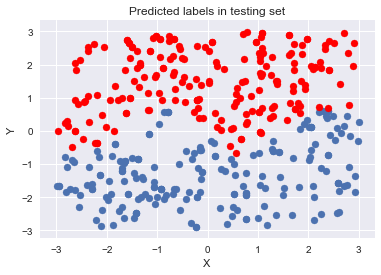

In [48]:
plt.figure(figsize=(12,12))
fig, ax = plt.subplots()
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
sns.despine()
ax.set(title='Predicted labels in testing set', xlabel='X', ylabel='Y',);
print((pred==y_test).sum()/len(pred))

In [ ]:
plt.figure(figsize=(12,12))
fig, ax = plt.subplots()
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
sns.despine()
ax.set(title='Predicted labels in testing set', xlabel='X', ylabel='Y',);
print((pred==y_test).sum()/len(pred))

0.9575


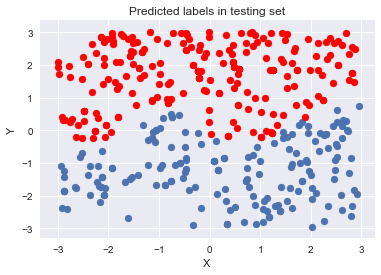

In [33]:
plt.figure(figsize=(12,12))
fig, ax = plt.subplots()
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
sns.despine()
ax.set(title='Predicted labels in testing set', xlabel='X', ylabel='Y',);
print((pred==y_test).sum()/len(pred))

## Regression

### Creating the data and the initial plot of the whole set

In [208]:
if os.path.exists("reg_data-"):
    with open("reg_data","rb") as f:
        data = pickle.load(f)
else:
    m = pm.Model()
    lower=-10
    upper=10
    with m:
        
        y = pm.MvStudentT("y", mu=np.array([0.,0.]), cov=np.array([[1.,0.],[0.,1.]]), nu=5)
        trace= pm.sample(500)
    #X = trace.get_values("x")
    y = trace.get_values("y")

    #data = [X, y]
    #with open("reg_data","wb") as f:
        #pickle.dump(data, f)

        
plt.figure(figsize=(16,8))
plt.title("Data set for function approximation example")
plt.ylabel("y")
plt.xlabel("x")
plt.scatter(X ,y)

ValueError: Invalid dimension for value: 0

In [28]:
def plot_ppc(X, y, algorithm, ppc, n_lines=500, pred=True, scatter=True):
    all_data = ppc["out"]
    idx = np.random.choice(range(all_data.shape[0]), size=n_lines, replace=False)
    plt.figure(figsize=(8,8))
    
    for i in idx:
        data = np.array([X_test[:,0], all_data[i,:]]).transpose()
        data = data[data[:,0].argsort()]
        plt.plot(data[:,0], data[:,1], alpha=0.01, c="r")
    if pred:
        pred = all_data.mean(axis=0)
        data = np.array([X_test[:,0], pred]).transpose()
        data = data[data[:,0].argsort()]
        plt.plot(data[:,0], data[:,1], c="r", lw=3)
    if scatter:
        plt.scatter(X[:,0],y)
    
    plt.title("Neural network regression with {} sampling".format(algorithm))
    plt.ylabel("y")    
    plt.xlabel("x")    

### Creating and sampling from the neural network model

In [29]:
X = pd.DataFrame(X)
X["1"] = 1
X = X.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [30]:
N=1000
n_units=5

init_in_1 = np.random.randn(X.shape[1], n_units)
init_1_2 = np.random.randn(n_units + 1, n_units)
init_2_out = np.random.randn(n_units + 1, 1)

### MHMCMC

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [w_2_out]
>Metropolis: [w_1_2]
>Metropolis: [w_in_1]
100%|██████████| 500/500 [00:00<00:00, 1289.16it/s]


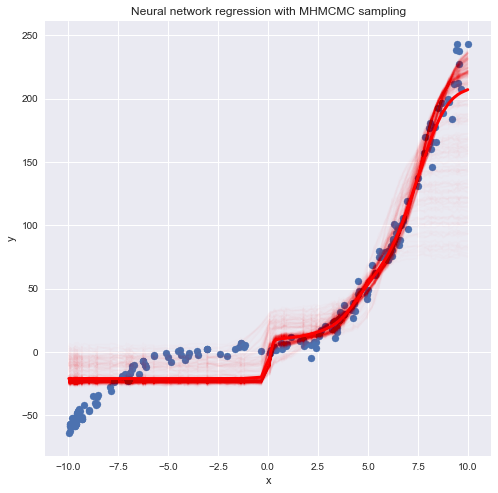

In [31]:
ann_input = theano.shared(X_train)
#ann_input = theano.shared(np.reshape(X_train, (len(X_train),1)))
ann_output = theano.shared(y_train)

mlc = pm.Model()
with mlc: 
    w_in_1 = pm.Normal("w_in_1", 0, 1, shape=(X.shape[1], n_units), testval=init_in_1)
    w_1_2 = pm.Normal("w_1_2", 0, 1, shape=(n_units + 1, n_units), testval=init_1_2)
    w_2_out = pm.Normal("w_2_out", 0, 1, shape=(n_units + 1, 1), testval=init_2_out)

    act_1 = T.nnet.sigmoid(T.dot(ann_input, w_in_1))
    act_1 = T.concatenate((act_1,T.ones((ann_input.shape[0],1))),axis=1)                          
    act_2 = T.nnet.sigmoid(T.dot(act_1, w_1_2))
    act_2 = T.concatenate((act_2,T.ones((act_1.shape[0],1))),axis=1)    
    act_out = T.dot(act_2,w_2_out)
    out = pm.Normal('out', act_out.flatten(), observed=ann_output)   
    
    step=pm.Metropolis()
    trace = pm.sample(N, step=step, tune=100)
    
ann_input.set_value(X_test)
ann_output.set_value(y_test)
ppc=pm.sample_ppc(trace, model=mlc, samples=500)

plot_ppc(X_test, y_test, "MHMCMC", ppc, n_lines=500)

In [33]:
sum_mh

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
w_in_1__0_0,3.573452,4.764825,0.476480,-1.168157,8.337878,1.0,109.156162
w_in_1__0_1,4.224629,3.136817,0.313682,1.089555,7.361443,1.0,942.454230
w_in_1__0_2,0.736116,0.164428,0.016441,0.571987,0.903911,1.0,23.421517
w_in_1__0_3,-3.077494,2.236036,0.223342,-5.090868,-0.891008,1.0,6.677386
w_in_1__0_4,1.932440,0.239346,0.023429,1.820636,1.965985,3.0,1.247662
w_in_1__1_0,4.141969,3.291762,0.329109,0.862768,7.314925,1.0,16.164312
w_in_1__1_1,0.418362,1.854496,0.185438,-1.467016,2.270706,1.0,29.326376
w_in_1__1_2,-2.465546,0.537438,0.052600,-2.712624,-2.394964,3.0,1.238733
w_in_1__1_3,2.770616,3.362734,0.336266,-0.555985,6.132031,1.0,50.479097
w_in_1__1_4,2.570080,2.951246,0.295052,-0.367591,5.403196,1.0,14.720497


In [32]:
sum_mh= pm.stats.summary(trace)

In [38]:
sns.distplot?

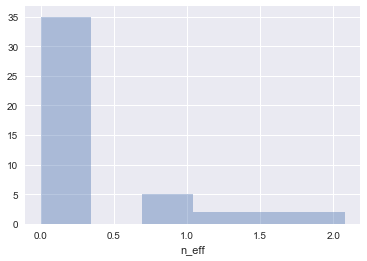

In [40]:
sns.distplot(np.log(sum_mh["n_eff"]), kde=False)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ffb213f0b00>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7ffb13138390>]], dtype=object)

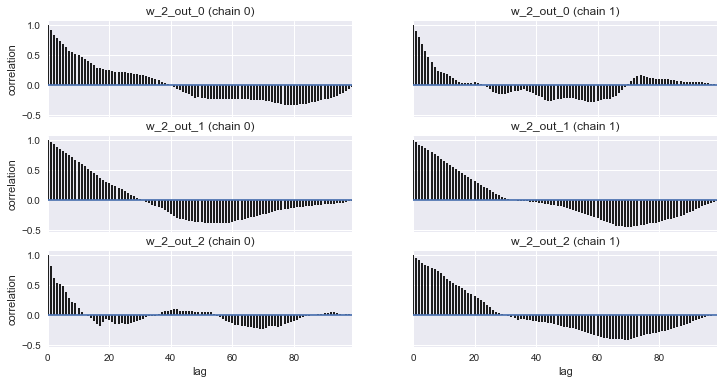

In [694]:
pm.plots.autocorrplot(trace, varnames=["w_2_out"])

### HMC-NUTS

In [ ]:
ann_input = theano.shared(X_train)
#ann_input = theano.shared(np.reshape(X_train, (len(X_train),1)))
ann_output = theano.shared(y_train)

mlc = pm.Model()
with mlc: 
    w_in_1 = pm.Normal("w_in_1", 0, 1, shape=(X.shape[1], n_units), testval=init_in_1)
    w_1_2 = pm.Normal("w_1_2", 0, 1, shape=(n_units + 1, n_units), testval=init_1_2)
    w_2_out = pm.Normal("w_2_out", 0, 1, shape=(n_units + 1, 1), testval=init_2_out)

    act_1 = T.nnet.sigmoid(T.dot(ann_input, w_in_1))
    act_1 = T.concatenate((act_1,T.ones((ann_input.shape[0],1))),axis=1)                          
    act_2 = T.nnet.sigmoid(T.dot(act_1, w_1_2))
    act_2 = T.concatenate((act_2,T.ones((act_1.shape[0],1))),axis=1)    
    act_out = T.dot(act_2,w_2_out)
    out = pm.Normal('out', act_out.flatten(), observed=ann_output)   
    
    step=pm.NUTS()
    trace = pm.sample(N, step=step)
    
ann_input.set_value(X_test)
ann_output.set_value(y_test)
ppc=pm.sample_ppc(trace, model=mlc, samples=500)

plot_ppc(X_test, y_test, "HMC-NUTS", ppc, n_lines=500)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w_2_out, w_1_2, w_in_1]
 17%|█▋        | 251/1500 [00:53<14:12,  1.46it/s]

In [ ]:
pm.stats.summary(trace)

In [ ]:
pm.plots.autocorrplot(trace, varnames=["w_2_out"])

### Outtakes

In [ ]:
def conduct_mlp_regressor(X_train, y_train, N, step, n_units=5):
    ann_input = theano.shared(X_train)
    #ann_input = theano.shared(np.reshape(X_train, (len(X_train),1)))
    ann_output = theano.shared(y_train)

    init_in_1 = np.random.randn(X.shape[1], n_units)
    init_1_2 = np.random.randn(n_units + 1, n_units)
    init_2_out = np.random.randn(n_units + 1, 1)
    mlc = pm.Model()
    with mlc: 
        w_in_1 = pm.Normal("w_in_1", 0, 1, shape=(X.shape[1], n_units), testval=init_in_1)
        w_1_2 = pm.Normal("w_1_2", 0, 1, shape=(n_units + 1, n_units), testval=init_1_2)
        w_2_out = pm.Normal("w_2_out", 0, 1, shape=(n_units + 1, 1), testval=init_2_out)

        act_1 = T.nnet.sigmoid(T.dot(ann_input, w_in_1))
        act_1 = T.concatenate((act_1,T.ones((ann_input.shape[0],1))),axis=1)                          
        act_2 = T.nnet.sigmoid(T.dot(act_1, w_1_2))
        act_2 = T.concatenate((act_2,T.ones((act_1.shape[0],1))),axis=1)    
        act_out = T.dot(act_2,w_2_out)
        out = pm.Normal('out', act_out.flatten(), observed=ann_output)
        if step=="mh":
            step = pm.Metropolis()
        elif step=="nuts":
            step = pm.NUTS()
        
        
        trace = pm.sample(N, step=step)
    return mlc, trace

In [564]:
X, y = make_circles(2100, noise = 0.15, factor=0.3)

In [565]:
data = np.concatenate((X,np.reshape(y,(-1,1))), axis=1)

In [566]:
data = data[data[:,1]>0][:1000]

In [567]:
d = data.copy()

In [568]:
d[:,:2] =     np.log(d[:,:2])

In [569]:
d = d[~np.isnan(d[:,0])]

In [570]:
d[:,:2] =    np.sin(d[:,:2])

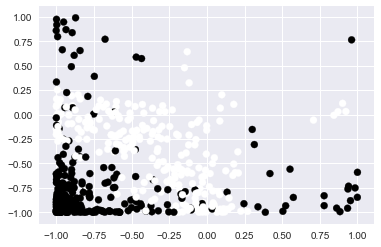

In [573]:
plt.scatter(d[:,0], d[:,1], c=d[:,2])

In [572]:
X = d[:,:2]
y = d[:,2]

In [647]:
ann_input = theano.shared(X_train)
ann_output = theano.shared(y_train)

N=1000
n_units = 5

init_in_1 = np.random.randn(X.shape[1], n_units)
init_1_2 = np.random.randn(n_units, n_units)
init_2_out = np.random.randn(n_units, 1)
mlc = pm.Model()
with mlc: 
    w_in_1 = pm.Normal("w_in_1", 0, 1, shape=(X.shape[1], n_units), testval=init_in_1)
    w_1_2 = pm.Normal("w_1_2", 0, 1, shape=(n_units, n_units), testval=init_1_2)
    w_2_out = pm.Normal("w_2_out", 0, 1, shape=(n_units, 1), testval=init_2_out)
    
    act_1 = T.tanh(T.dot(ann_input, w_in_1))
    act_2 = T.tanh(T.dot(act_1, w_1_2))
    act_out = T.nnet.sigmoid(T.dot(act_2, w_2_out))
    
    # Binary classification -> Bernoulli likelihood
    out = pm.Bernoulli('out', act_out.flatten(), observed=ann_output)

    step = pm.NUTS()
    trace = pm.sample(N, step=step)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w_2_out, w_1_2, w_in_1]
100%|█████████▉| 1498/1500 [05:44<00:00, 25.45it/s] /usr/local/lib/python3.5/dist-packages/pymc3-3.2-py3.5.egg/pymc3/step_methods/hmc/nuts.py:452: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0692820579981, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/usr/local/lib/python3.5/dist-packages/pymc3-3.2-py3.5.egg/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 0 contains 847 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 1500/1500 [05:44<00:00,  4.35it/s]
/usr/local/lib/python3.5/dist-packages/pymc3-3.2-py3.5.egg/pymc3/step_methods/hmc/nuts.py:460: UserWarning: Chain 1 reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
  'reparameterize.' % self.